In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from scipy import stats
from autorank import autorank,create_report,plot_stats
from significance_analysis import conduct_analysis
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [2]:
best={}
ranges={}
for benchmark in df["benchmark"].unique():
    best[benchmark]=min(df.loc[df["benchmark"]==benchmark]["value"])
    ranges[benchmark]=max(df.loc[df["benchmark"]==benchmark]["value"])-best[benchmark]
    

def calculate_simple_regret(row):
    return abs(best[row["benchmark"]]-row["value"])/ranges[row["benchmark"]]

df['value'] = df.apply(calculate_simple_regret, axis=1)

In [3]:
algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
prior_dict={"good+bad":["at25","bad"]}
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PriorBand+BO"}

for priortype in df["prior"].unique():
    prior_dict[priortype]=[priortype]

df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for b_n,benchmark in enumerate(benchmarks):
        print(f"Prior {prior_key}, Benchmark {b_n+1}/{len(benchmarks)}      ", end="\r", flush=True)
        df_dict[prior_key][benchmark]={}
        for algo_key,algo_value in algo_dict.items():
            df_dict[prior_key][benchmark][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)].reset_index(drop=True)

In [4]:
def create_lmem_incumbent(priors:list[str],fs,algorithms:list[str],algo_group:str,benchmarks:list[str],df_dict):
    output={}
    output["dataset"]={}
    for p_n,prior in enumerate(priors):
        output["dataset"][prior]={}
        for n_f,max_f in enumerate(fs):
            output["dataset"][prior][max_f]={}
            output["dataset"][prior][max_f]=pd.DataFrame()
            for b_n,benchmark in enumerate(benchmarks):
                df_at_point=df_dict[prior][benchmark][algo_group]
                df_at_point=df_at_point.loc[df_at_point["used_fidelity"]<=max_f]
                for seed in df_at_point["seed"].unique():
                    print(f"Prior {prior} ({p_n+1}), Fidelity {n_f+1}/{len(fs)}, Benchmark {b_n+1}/{len(benchmarks)}          ", end="\r", flush=True)
                    for algo in algorithms:
                        df_criteria=df_at_point.loc[(df_at_point["seed"]==seed)&(df_at_point["algorithm"]==algo)].iloc[-1].to_frame().T
                        df_criteria["used_fidelity"]=max_f
                        output["dataset"][prior][max_f]=pd.concat([output["dataset"][prior][max_f],df_criteria],ignore_index=True)
            output["dataset"][prior][max_f][["value","used_fidelity"]]=output["dataset"][prior][max_f][["value","used_fidelity"]].astype(float)
            output["dataset"][prior][max_f]["seed"]=output["dataset"][prior][max_f]["seed"].astype(int)
    return output["dataset"]


In [5]:


fig5={}
fig5["algo_group"]="rs_hb_pb"
fig5["algorithms"]=algo_dict[fig5["algo_group"]].copy()
fig5["priors"]=["good+bad","at25","bad"]
fig5["benchmarks"]=benchmarks
fig5["max_f"]=[1.0,5.0,12.0]#range(1,13)

fig5["dataset"]=create_lmem_incumbent(fig5["priors"],fig5["max_f"],fig5["algorithms"],fig5["algo_group"],fig5["benchmarks"],df_dict)

In [6]:
result_dict={}
for p_n,priortype in enumerate(fig5["priors"]):
    result_dict[priortype]={}
    for f_n,max_f in enumerate(fig5["max_f"]):
        print(f"Prior {priortype} ({p_n+1}), Fidelity {f_n+1}/{len(fig5['max_f'])}")
        fig5["dataset"][priortype][max_f]=fig5["dataset"][priortype][max_f].replace({"algorithm": label_dict,"benchmark": label_dict})
        result_dict[priortype][max_f]=conduct_analysis(fig5["dataset"][priortype][max_f],"value","algorithm","benchmark",continuous_fidelity=False,show_plots=False,verbosity=0)[1]

Prior good+bad (1), Fidelity 1/3
P-values adjusted by tukey method for family of 3 estimates
Prior good+bad (1), Fidelity 2/3
P-values adjusted by tukey method for family of 3 estimates
Prior good+bad (1), Fidelity 3/3
P-values adjusted by tukey method for family of 3 estimates
Prior at25 (2), Fidelity 1/3
P-values adjusted by tukey method for family of 3 estimates
Prior at25 (2), Fidelity 2/3
P-values adjusted by tukey method for family of 3 estimates
Prior at25 (2), Fidelity 3/3
P-values adjusted by tukey method for family of 3 estimates
Prior bad (3), Fidelity 1/3
P-values adjusted by tukey method for family of 3 estimates
Prior bad (3), Fidelity 2/3
P-values adjusted by tukey method for family of 3 estimates
Prior bad (3), Fidelity 3/3
P-values adjusted by tukey method for family of 3 estimates


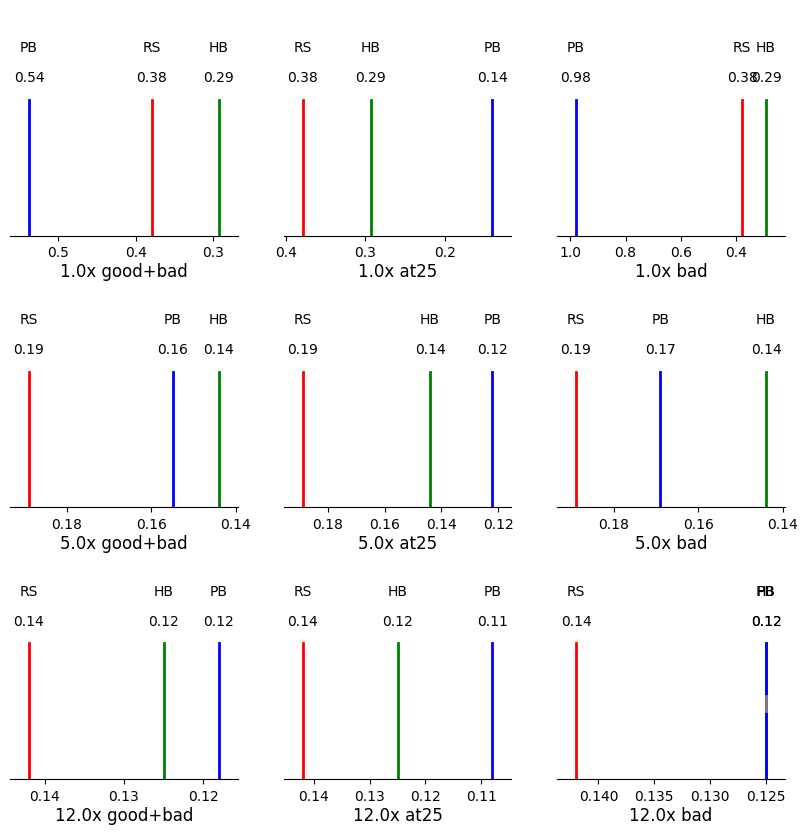

In [7]:

color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue","RS":"red","HB":"green","PB":"blue"}


_,axes = plt.subplots(len(fig5["max_f"]),len(fig5["priors"]),figsize=(10,10*len(fig5["max_f"])/3))
for p_n,prior in enumerate(fig5["priors"]):
    for f_n,fidelity in enumerate(fig5["max_f"]):
        scoreframe=result_dict[prior][fidelity][0].sort_values(by=['Estimate'])[["algorithm","Estimate"]]
        contrastframe=result_dict[prior][fidelity][1][["Sig","algorithm_1","algorithm_2"]]

        min_score=scoreframe["Estimate"][0]
        max_score=scoreframe["Estimate"][len(scoreframe["Estimate"])-1]

        algo_lines_x=scoreframe["Estimate"].values.tolist()

        significance_lines=[]
        for n_best_algo,best_algo in enumerate(scoreframe["algorithm"]):
            for n_worst_algo,worst_algo in reversed(list(enumerate(scoreframe["algorithm"][n_best_algo+1:]))):
                significance=contrastframe.loc[((contrastframe["algorithm_1"]==best_algo)&(contrastframe["algorithm_2"]==worst_algo))|((contrastframe["algorithm_2"]==best_algo)&(contrastframe["algorithm_1"]==worst_algo))]["Sig"][0]
                if significance in ["","."]:
                    new_line=[n_best_algo,n_best_algo+n_worst_algo+1]
                    if not any(existing_pair[0] <= new_line[0] <= existing_pair[1] and existing_pair[0] <= new_line[1] <= existing_pair[1] for existing_pair in significance_lines):
                        significance_lines.append([n_best_algo,n_best_algo+n_worst_algo+1])
                        break
                

        n_sign_lines=len(significance_lines)
        plot_height=10+5

        if len(fig5["priors"])>1:
            ax=axes[f_n,p_n]
        else:
            ax=axes[f_n]
        ax.set_title(f"{fidelity}x {prior}",pad=0,y=-0.18)
        ax.get_yaxis().set_visible(False)
        ax.set_xlim(min_score-(max_score-min_score)*0.1,max_score+(max_score-min_score)*0.1)
        ax.set_ylim(0,plot_height)
        ax.spines['bottom'].set_position(('data', 0.0))
        ax.spines[['top',"left","right"]].set_visible(False)
        ax.invert_xaxis()

        for algo in range(len(scoreframe["Estimate"])):
            ax.plot([scoreframe["Estimate"][algo],scoreframe["Estimate"][algo]], [0, plot_height-6], '-', lw=2, label="_not in legend",color=color_dict[scoreframe["algorithm"][algo]])
            ax.text(scoreframe["Estimate"][algo], plot_height-3, scoreframe["algorithm"][algo], horizontalalignment='center',verticalalignment='bottom')
            ax.text(scoreframe["Estimate"][algo], plot_height-5, np.round(scoreframe["Estimate"][algo],2), horizontalalignment='center',verticalalignment='bottom')
        for n_line,line in enumerate(significance_lines):
            if scoreframe["Estimate"][line[0]]==scoreframe["Estimate"][line[1]]:
                ax.plot([scoreframe["Estimate"][line[0]], scoreframe["Estimate"][line[1]]],[10/(n_sign_lines+1)*(n_line+1)-0.5,10/(n_sign_lines+1)*(n_line+1)+0.5],  '-', lw=2, label="_not in legend",color="gray")
            else:
                ax.plot([scoreframe["Estimate"][line[0]], scoreframe["Estimate"][line[1]]],[10/(n_sign_lines+1)*(n_line+1),10/(n_sign_lines+1)*(n_line+1)],  '-', lw=6, label="_not in legend",color="gray")


plt.show()

